In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%pip install transformers opencv-python datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 90.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 43.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 105.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 17.4 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [3]:
!unzip drive/MyDrive/archive.zip -d dataset

Archive:  drive/MyDrive/archive.zip
   creating: dataset/crackdataset/dataset/.ipynb_checkpoints/
   creating: dataset/crackdataset/dataset/predict/.ipynb_checkpoints/
  inflating: dataset/crackdataset/dataset/predict/sub/IMG_1134.JPG  
  inflating: dataset/crackdataset/dataset/predict/sub/IMG_1133.JPG  
  inflating: dataset/crackdataset/dataset/predict/sub/IMG_1129.JPG  
  inflating: dataset/crackdataset/dataset/valid/Positive/IMG_9642_10_12.jpg  
  inflating: dataset/crackdataset/dataset/valid/Positive/IMG_9299_7_12.jpg  
  inflating: dataset/crackdataset/dataset/valid/Positive/IMG_9178_9_18.jpg  
  inflating: dataset/crackdataset/dataset/valid/Positive/IMG_9221_6_11.jpg  
  inflating: dataset/crackdataset/dataset/valid/Positive/IMG_9115_9_10.jpg  
  inflating: dataset/crackdataset/dataset/valid/Positive/IMG_9720_11_4.jpg  
  inflating: dataset/crackdataset/dataset/valid/Positive/IMG_9620_8_11.jpg  
  inflating: dataset/crackdataset/dataset/valid/Positive/IMG_9146_9_9.jpg  
  inflati

In [ ]:
!mv dataset/valid .
!mv dataset/test .
!mv dataset/predict .

In [4]:
from transformers import AutoImageProcessor, Swinv2ForImageClassification, TrainingArguments, Trainer, AutoConfig
from datasets import load_dataset, load_metric
from PIL import Image
import requests
import torch
import cv2
import albumentations as A
import numpy as np
import matplotlib.pyplot as plt

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
metric = load_metric("accuracy")
metricp = load_metric("precision")
metricr = load_metric("recall")
metricf1 = load_metric("f1")
def compute_metrics(p):
    return {"accuracy":metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids),\
      "precision":metricp.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids),\
      "recall":metricr.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids),\
      "f1":metricf1.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)}

<ipython-input-6-eb2c66e69d09>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [7]:
dataset = load_dataset("imagefolder", data_dir="dataset/", drop_labels=False)

Resolving data files:   0%|          | 0/1200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/800 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/200 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/default-7bbac0eab7eb4648/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/600 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/default-4404d97c5e3e6ff9/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

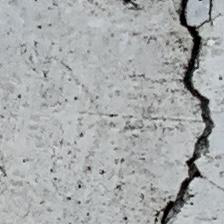

1

In [8]:
train_dataset = load_dataset("imagefolder", data_dir="dataset/crackdataset/dataset/train", drop_labels=False)
display(train_dataset['train'][-1]['image'])
train_dataset['train'][-1]['label']

In [9]:
train_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 600
    })
})

In [10]:
validation_dataset = load_dataset("imagefolder", data_dir="dataset/crackdataset/dataset/valid", drop_labels=False)
validation_dataset

Resolving data files:   0%|          | 0/200 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/default-c2512b942eb35475/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 200
    })
})

In [11]:
test_dataset = load_dataset("imagefolder", data_dir="dataset/crackdataset/dataset/test", drop_labels=False)
test_dataset

Resolving data files:   0%|          | 0/600 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/default-c8748444066ee976/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 600
    })
})

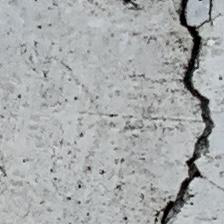

1

In [12]:
display(test_dataset['train'][-1]['image'])
test_dataset['train'][-1]['label']

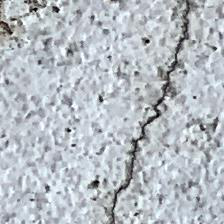

1

In [13]:
display(validation_dataset['train'][-1]['image'])
validation_dataset['train'][-1]['label']

In [14]:
feature_extractor = AutoImageProcessor.from_pretrained("microsoft/swinv2-base-patch4-window16-256")

Downloading:   0%|          | 0.00/240 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [15]:
transform = A.Compose([
    A.Resize(width=256, height=256, always_apply=True),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=1),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.1, p=0.5),
    A.GaussNoise(var_limit=(10.0, 200.0), p=0.5),
    A.AdvancedBlur(blur_limit=(3, 7), p=0.5),
    # A.CLAHE(clip_limit=2.0, p=1)
])

In [16]:
# def transforms(examples):
#     examples["pixel_values"] = [transform(image=np.array(image))["image"] for image in examples["image"]]
#     return examples

def transform_and_extract(batch):
    inputs = feature_extractor(
        [transform(image=np.array(image))["image"] for image in batch["image"]],
        return_tensors='pt'
    )
    inputs['labels'] = batch['label']
    return inputs

In [17]:
train_dataset.set_transform(transform_and_extract)
validation_dataset.set_transform(transform_and_extract)
test_dataset.set_transform(transform_and_extract)

In [18]:
img = train_dataset["train"][0]
img
# plt.imshow(img)
# plt.imshow(transform(image=np.array(Image.open('dataset/predict/IMG_1129.JPG')))["image"])

{'pixel_values': tensor([[[ 0.9303,  0.6392,  0.4508,  ...,  0.3138, -0.1657,  0.0056],
          [ 0.5536,  0.4337,  0.0398,  ..., -0.1828,  0.2282,  0.0398],
          [ 0.8618,  0.7077,  0.5707,  ...,  0.2282,  0.5193,  0.5364],
          ...,
          [-1.8439, -1.5528, -0.9877,  ...,  1.0331,  0.8789,  1.0673],
          [-2.1179, -1.9638, -1.7412,  ...,  0.9132,  0.8789,  0.8447],
          [-2.1179, -2.1179, -2.1179,  ...,  1.1015,  0.9303,  0.9988]],
 
         [[ 1.2731,  0.9930,  0.6429,  ...,  0.2227,  0.1877,  0.2927],
          [ 1.0105,  0.9930,  0.6954,  ..., -0.0224, -0.0574,  0.3277],
          [ 1.0280,  0.8880,  0.9055,  ...,  0.2577,  0.5378,  0.7304],
          ...,
          [-1.7556, -1.2654, -0.6001,  ...,  0.9930,  0.9055,  0.6954],
          [-1.9832, -2.0357, -1.6155,  ...,  1.1506,  1.2031,  1.0980],
          [-2.0357, -1.8256, -2.0357,  ...,  1.2381,  1.3256,  1.2556]],
 
         [[ 1.5942,  1.2282,  0.8797,  ...,  0.4091,  0.2173,  0.4091],
          [ 

In [19]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

In [20]:
metric = load_metric("accuracy")
metricp = load_metric("precision")
metricr = load_metric("recall")
metricf1 = load_metric("f1")
def compute_metrics(p):
    return {"accuracy":metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids),\
      "precision":metricp.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids),\
      "recall":metricr.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids),\
      "f1":metricf1.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)}

In [21]:
labels = train_dataset['train'].features['label'].names

# config = AutoConfig.from_pretrained("microsoft/swinv2-base-patch4-window16-256")
# config.num_labels = len(labels)
# config.id2label = {str(i): c for i, c in enumerate(labels)}
# config.label2id = {c: str(i) for i, c in enumerate(labels)}
# model = Swinv2ForImageClassification.from_config(config)

model = Swinv2ForImageClassification.from_pretrained(
    "microsoft/swinv2-base-patch4-window16-256",
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)},
    ignore_mismatched_sizes=True
)

Downloading:   0%|          | 0.00/69.9k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/352M [00:00<?, ?B/s]

Some weights of Swinv2ForImageClassification were not initialized from the model checkpoint at microsoft/swinv2-base-patch4-window16-256 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([2, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
# out = model(torch.stack((dataset['train'][0]['pixel_values'],)).to(device))
# out.pooler_output.shape

In [23]:
training_args = TrainingArguments(
  output_dir="./swin-base-cracks",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

In [24]:
train_dataset,\
validation_dataset,\
test_dataset

(DatasetDict({
     train: Dataset({
         features: ['image', 'label'],
         num_rows: 600
     })
 }), DatasetDict({
     train: Dataset({
         features: ['image', 'label'],
         num_rows: 200
     })
 }), DatasetDict({
     train: Dataset({
         features: ['image', 'label'],
         num_rows: 600
     })
 }))

In [25]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset["train"],
    eval_dataset=validation_dataset["train"],
    tokenizer=feature_extractor,
)

Using cuda_amp half precision backend


In [26]:
train_dataset['train']

Dataset({
    features: ['image', 'label'],
    num_rows: 600
})

In [27]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 600
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 152
  Number of trainable parameters = 86895866


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
100,0.000500,0.003225,{'accuracy': 1.0},{'precision': 1.0},{'recall': 1.0},{'f1': 1.0}


***** Running Evaluation *****
  Num examples = 200
  Batch size = 8
Trainer is attempting to log a value of "{'accuracy': 1.0}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 1.0}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 1.0}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 1.0}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to ./swin-base-cracks/checkpoint-100
Configuration saved 

***** train metrics *****
  epoch                    =         4.0
  total_flos               = 229119959GF
  train_loss               =      0.0841
  train_runtime            =  0:02:58.93
  train_samples_per_second =      13.412
  train_steps_per_second   =       0.849


In [ ]:
metrics = trainer.evaluate(validation_dataset['train'])
trainer.log_metrics("eval", metrics['accuracy'])
trainer.save_metrics("eval", metrics['accuracy'])

***** Running Evaluation *****
  Num examples = 200
  Batch size = 8


Trainer is attempting to log a value of "{'accuracy': 0.995}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.9900990099009901}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 1.0}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9950248756218906}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


KeyError: ignored

In [ ]:
metrics = trainer.evaluate(dataset['test'])
trainer.log_metrics("test", metrics)
trainer.save_metrics("test", metrics)

In [28]:
!pip install split-image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [53]:
!split-image 'dataset/crackdataset/dataset/predict/sub/IMG_1132.JPG' 7 7

Exporting image tile: ./IMG_1132_0.JPG
Exporting image tile: ./IMG_1132_1.JPG
Exporting image tile: ./IMG_1132_2.JPG
Exporting image tile: ./IMG_1132_3.JPG
Exporting image tile: ./IMG_1132_4.JPG
Exporting image tile: ./IMG_1132_5.JPG
Exporting image tile: ./IMG_1132_6.JPG
Exporting image tile: ./IMG_1132_7.JPG
Exporting image tile: ./IMG_1132_8.JPG
Exporting image tile: ./IMG_1132_9.JPG
Exporting image tile: ./IMG_1132_10.JPG
Exporting image tile: ./IMG_1132_11.JPG
Exporting image tile: ./IMG_1132_12.JPG
Exporting image tile: ./IMG_1132_13.JPG
Exporting image tile: ./IMG_1132_14.JPG
Exporting image tile: ./IMG_1132_15.JPG
Exporting image tile: ./IMG_1132_16.JPG
Exporting image tile: ./IMG_1132_17.JPG
Exporting image tile: ./IMG_1132_18.JPG
Exporting image tile: ./IMG_1132_19.JPG
Exporting image tile: ./IMG_1132_20.JPG
Exporting image tile: ./IMG_1132_21.JPG
Exporting image tile: ./IMG_1132_22.JPG
Exporting image tile: ./IMG_1132_23.JPG
Exporting image tile: ./IMG_1132_24.JPG
Exporting 

In [54]:
pred_result = 0
for i in range(49):
  pred_image = Image.open(f'./IMG_1132_{i}.JPG')
  ex_features = feature_extractor([pred_image], return_tensors='pt')['pixel_values']
  out = model(ex_features.to(device))
  res = torch.argmax(out.logits, dim=-1)
  if(res == 1):
    print(i)
    pred_result = 1
    # break

pred_result

3
10
17
24
31
38


1

In [ ]:
neg_image = Image.open('dataset/crackdataset/dataset/test/Negative/DJI_0669_14_9.jpg')
pos_image = Image.open('dataset/crackdataset/dataset/test/Positive/DJI_0677_14_17.jpg')
pred_image = Image.open('dataset/crackdataset/dataset/predict/sub/IMG_1132.JPG')
ex_features = feature_extractor([neg_image, pos_image, pred_image], return_tensors='pt')['pixel_values']
out = model(ex_features.to(device))
out.logits, torch.argmax(out.logits, dim=-1)

(tensor([[ 5.4084, -5.1434],
         [-7.7174,  7.2737],
         [ 4.8031, -4.6215]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([0, 1, 0], device='cuda:0'))

In [ ]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
pytorch_total_params, pytorch_total_trainable_params

(86895866, 86895866)